In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = "datasets/HPA_challenge_2018/Hirano3D/"
# data_path = Path(PATH)

#### CV generation via sklearn, Multilabel implementation by trent-b, or FastAi

Both libraries seem to be completely useless... can just use native fastai function: get_cv_idxs().<br>
However, get_cv_idxs() does NOT shuffle...!

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_label_stratified_CV_idxs(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### sklearn.model_selection.StratifiedKFold
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    
    for train_index, val_index in sss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def get_label_stratified_CV_idxs_multi(csv_path):
    
    # FastAi csv_source expects a folder-name string to be passed as first arg... -> 'dummy'
    X, y, all_lbls = csv_source('dummy', csv_path)
    
    ### Iterative stratification library: https://github.com/trent-b/iterative-stratification
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2)
    
    for train_index, val_index in msss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    trn_count = np.sum(y[trn_idxs], axis=0)
    val_count = np.sum(y[val_idxs], axis=0)
    
    print(f"""Train label-distribution:\n"""
          f"""{trn_count}""")
    print(f"""Val label-distribution:\n"""
          f"""{val_count}""")
    
    return trn_idxs, val_idxs

In [5]:
import pickle

# idxs_dict = {'trn_idxs': trn_idxs, 'val_idxs': val_idxs}

# with open('datasets/HPA_challenge_2018/tmp/dn121_AWS_1_cont_idxs.pkl', 'wb') as handle:
#     pickle.dump(idxs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('datasets/HPA_challenge_2018/Hirano3D/Hirano3D_AWS_idxs.pkl', 'rb') as handle:
    idxs_dict_load = pickle.load(handle)
    
val_idxs_loaded = idxs_dict_load['val_idxs']

In [ ]:
# setting up a list of a random 20% of images in train as the validation set

# lbl_csv = path + 'Kaggle_AND_HPAv18_60x_NoDefDupes_labels.csv'
# n = len(list(open(lbl_csv))) -1
# val_idxs = get_cv_idxs(n, val_pct=0.2)


# Count labels
# _all_labels = pd.read_csv(PATH + 'multi_folder_Hirano3D_02.csv')
# print(_all_labels.Targets.value_counts())

# _arr = _all_labels.values
# _val_labels = pd.DataFrame(_arr[val_idxs], columns=['Id','Targets'])
# print(_val_labels.Targets.value_counts())

In [ ]:
# l = os.listdir('datasets/HPA_challenge_2018/HPAv18_GBRY_60x_def_dupes_removed_all')
# l[0]

### Define Dataloader:

In [6]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(path, 'data', lbl_csv, 
                                        val_idxs = val_idxs,
                                        test_name='data/8bit_Hirano3D_MaxP_GRFB_test_512', 
                                        tfms=tfms, bs=bs, suffix = '.tif', 
                                        balance=True, num_workers=0)
    return data

In [7]:
# define augmentations
augs = [RandomDihedral(),RandomRotate(90)]
NUM_CLASSES = 4
bs = 16
sz = [4,512,512]
lbl_csv = path + '8bit_multi_folder_Hirano3D_v1.csv'
# initialize data object
data = get_data(path, lbl_csv, val_idxs_loaded, sz, bs, aug_tfms = augs)

Internal Normalization
val_crop is: 2
Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


In [8]:
x, y = next(iter(data.trn_dl))
im = to_np(x)[0]
im.shape
# x_test, y_test = next(iter(data.test_dl))

(4, 512, 512)

In [ ]:
# print transformations
# plt.style.use('seaborn-white')

c = 0
idx = 0
fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
#     ax.imshow(np.sum(im, axis = 0))
    ax.imshow(im[c])

In [ ]:
# loading epoch for manual inspection...

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


### inpsecting loaded images and labels

In [ ]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

In [ ]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

# lbl = to_np(y)[idx]
lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [ ]:
torch.cuda.is_available()

In [9]:
import copy

def check_model_loading(learn_obj, loaded_state_dict):
    learn_weight0 = list(copy.deepcopy(learn_obj.models.model.state_dict()).items())[0] # need deepcopy here
    learn_weight10 = list(copy.deepcopy(learn_obj.models.model.state_dict()).items())[604] # need deepcopy here

    learn_obj.models.model.load_state_dict(loaded_state_dict, strict=False)
    learn_weight0_loaded = list(learn_obj.models.model.state_dict().items())[0]
    learn_weight10_loaded = list(learn_obj.models.model.state_dict().items())[604]

#     print('weights_0:')
#     print(learn_weight0[1][0] - learn_weight0_loaded[1][0])
#     print('weights_10:')
#     print(learn_weight10[1][0] - learn_weight10_loaded[1][0])

In [10]:
saved_state_dict_path = 'datasets/HPA_challenge_2018/models/HPAv18_bs64_sz256_rCrp_dn121_v2_2_val_009.h5'
loaded_state_dict = torch.load(saved_state_dict_path)

In [11]:
# truncating saved model_state_dict()

loaded_state_dict_trunc = copy.deepcopy(loaded_state_dict)
del_keys = list(loaded_state_dict_trunc.keys())[604:]
for key in del_keys: del loaded_state_dict_trunc[key]

print('loaded_state_dict # keys: ', len(loaded_state_dict.keys()))    
print('loaded_state_dict_trunc # keys: ', len(loaded_state_dict_trunc.keys()))    

# Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in learn.models.model.state_dict():
#     print(param_tensor, "\t", learn.models.model.state_dict()[param_tensor].size())

loaded_state_dict # keys:  616
loaded_state_dict_trunc # keys:  604


In [12]:
arch = dn121_c

learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0.5, pretrained=False)
check_model_loading(learn, loaded_state_dict_trunc)

In [13]:
# additional parameters

wd=1e-4 # weight-decay/L2 regularization 
# learn.metrics = [accuracy, f1_micro]

In [14]:
learn.unfreeze()

In [15]:
lrs = np.array([1e-6,1e-4,1e-3])

In [16]:
%time learn.fit(lrs, 2, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_512_transferHPA_v1')

EPOCH 0 ---------------------------------------- STEP 0   
epoch      trn_loss   val_loss   accuracy   
    0      1.533484   1.259084   0.506024  
EPOCH 1 ---------------------------------------- STEP 1   
    1      1.306975   1.105823   0.53012   

creating log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
CPU times: user 4min 15s, sys: 25.9 s, total: 4min 41s
Wall time: 4min 35s


[array([1.10582]), 0.530120482286775]

In [17]:
%time learn.fit(lrs, 3, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_512_transferHPA_v1')

EPOCH 0 ---------------------------------------- STEP 2   
epoch      trn_loss   val_loss   accuracy   
    0      1.119408   1.249912   0.518072  
EPOCH 1 ---------------------------------------- STEP 3   
    1      1.043418   1.140043   0.53012   
EPOCH 2 ---------------------------------------- STEP 4   
    2      1.031245   1.063561   0.560241  

appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
CPU times: user 6min 23s, sys: 34.1 s, total: 6min 57s
Wall time: 6min 48s


[array([1.06356]), 0.5602409638554217]

In [18]:
lrs = np.array([1e-4,5e-4,1e-3])

In [19]:
%time learn.fit(lrs, 4, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_512_transferHPA_v1')

EPOCH 0 ---------------------------------------- STEP 5   
epoch      trn_loss   val_loss   accuracy   
    0      1.08316    1.152153   0.53012   
EPOCH 1 ---------------------------------------- STEP 6    
    1      0.944399   1.225646   0.566265  
EPOCH 2 ---------------------------------------- STEP 7    
    2      0.909283   1.10834    0.590361  
EPOCH 3 ---------------------------------------- STEP 8    
    3      0.804855   1.007621   0.596386  

appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
CPU times: user 8min 31s, sys: 45.1 s, total: 9min 16s
Wall time: 9min 5s


[array([1.00762]), 0.5963855421686747]

In [20]:
wd = 1e-3

In [21]:
%time learn.fit(lrs, 4, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_512_transferHPA_v2')

EPOCH 0 ---------------------------------------- STEP 9    
epoch      trn_loss   val_loss   accuracy   
    0      0.902267   1.205712   0.566265  
EPOCH 1 ---------------------------------------- STEP 10   
    1      0.745801   1.151965   0.572289  
EPOCH 2 ---------------------------------------- STEP 11   
    2      0.697623   1.05382    0.60241   
EPOCH 3 ---------------------------------------- STEP 12   
    3      0.692708   0.974555   0.60241   

appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
CPU times: user 8min 31s, sys: 45.1 s, total: 9min 16s
Wall time: 9min 3s


[array([0.97455]), 0.6024096385542169]

In [22]:
%time learn.fit(1e-4, 4, wds=wd, use_wd_sched=True, best_save_name='Hirano3D_dn121_512_transferHPA_v3')

EPOCH 0 ---------------------------------------- STEP 13   
epoch      trn_loss   val_loss   accuracy   
    0      0.554884   0.95452    0.614458  
EPOCH 1 ---------------------------------------- STEP 14   
    1      0.520966   0.893683   0.626506  
EPOCH 2 ---------------------------------------- STEP 15   
    2      0.467085   0.926303   0.60241   
EPOCH 3 ---------------------------------------- STEP 16   
    3      0.457922   0.983832   0.620482  

appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/Hirano3D/
CPU times: user 8min 30s, sys: 46.7 s, total: 9min 17s
Wall time: 9min 5s


[array([0.98383]), 0.6204819284289717]

In [23]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_dn121_512_transferHPA_v4')

EPOCH 0 ---------------------------------------- STEP 17   
epoch      trn_loss   val_loss   accuracy   
    0      0.524163   1.478992   0.53012   
EPOCH 1 ---------------------------------------- STEP 18   
    1      0.706804   1.323869   0.506024  
EPOCH 2 ---------------------------------------- STEP 19   
    2      0.685119   1.187399   0.572289  
EPOCH 3 ---------------------------------------- STEP 20   
    3      0.620629   0.984921   0.674699  
EPOCH 4 ---------------------------------------- STEP 21   
    4      0.607244   1.069384   0.614458  
EPOCH 5 ---------------------------------------- STEP 22   
    5      0.505628   0.975346   0.644578  
EPOCH 6 ---------------------------------------- STEP 23   
    6      0.450526   1.02132    0.644578  
EPOCH 7 ---------------------------------------- STEP 24   
    7      0.396202   0.959084   0.698795  
EPOCH 8 ---------------------------------------- STEP 25   
    8      0.382718   1.245899   0.596386  
EPOCH 9 -----------

[array([0.9292]), 0.7048192763903055]

In [11]:
arch = dn121_c
wd = 1e-3
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0.5, pretrained=False)

In [12]:
learn.load('Hirano3D_dn121_512_transferHPA_v4')

In [13]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_dn121_512_transferHPA_v5')

EPOCH 0 ---------------------------------------- STEP 0    
epoch      trn_loss   val_loss   accuracy   
    0      0.228102   0.937856   0.704819  
EPOCH 1 ---------------------------------------- STEP 1    
    1      0.215028   1.016051   0.728916  
EPOCH 2 ---------------------------------------- STEP 2    
    2      0.216698   1.036658   0.716867  
EPOCH 3 ---------------------------------------- STEP 3    
    3      0.185915   1.012291   0.692771  
EPOCH 4 ---------------------------------------- STEP 4    
    4      0.216514   1.057943   0.686747  
EPOCH 5 ---------------------------------------- STEP 5    
    5      0.196268   1.042959   0.680723  
EPOCH 6 ---------------------------------------- STEP 6    
    6      0.164228   1.071928   0.680723  
EPOCH 7 ---------------------------------------- STEP 7    
    7      0.176888   1.093766   0.680723  
EPOCH 8 ---------------------------------------- STEP 8    
    8      0.152491   1.044826   0.686747  
EPOCH 9 -----------

[array([1.12224]), 0.6987951800047633]

In [ ]:
p = learn.sched

_iter_log = [[p.iterations[i], p.losses[i], p.lrs[i]] for i in range(len(p.iterations))]
_epoch_log = [[p.glob_step[i], p.val_losses[i], *p.rec_metrics[i]] for i in range(len(p.glob_step))]

_iter_log = pd.DataFrame(_iter_log, columns=["Iterations", 'trn_oss', 'Lr'])
_epoch_log = pd.DataFrame(_epoch_log, columns=['Global_step','val_loss','metric_1', 'f1_macro'])

_iter_log.to_csv('datasets/HPA_challenge_2018/logs/iter_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv', index=False) 
_epoch_log.to_csv('datasets/HPA_challenge_2018/logs/epoch_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv', index=False)

In [ ]:
p = learn.sched

_iter_log = [[p.iterations[i], p.losses[i], p.lrs[i]] for i in range(len(p.iterations))]
_epoch_log = [[p.glob_step[i], p.val_losses[i], *p.rec_metrics[i]] for i in range(len(p.glob_step))]

_iter_log = pd.DataFrame(_iter_log, columns=["Iterations", 'trn_oss', 'Lr'])
_epoch_log = pd.DataFrame(_epoch_log, columns=['Global_step','val_loss','metric_1', 'f1_macro'])

_iter_log.to_csv('datasets/HPA_challenge_2018/logs/iter_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv', header=False, index=False, mode='a') 
_epoch_log.to_csv('datasets/HPA_challenge_2018/logs/epoch_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv', header=False, index=False, mode='a')

In [14]:
learn.load('Hirano3D_dn121_512_transferHPA_v4')

In [15]:
learn.freeze_to(3)

## test-predictions

In [ ]:
log_preds, y = learn.predict_with_targs()
preds = np.argmax(log_preds, axis=1)
print(preds)

In [16]:
log_preds, y =  learn.TTA(8)

[[42  3 13  7]
 [ 1 25  2  5]
 [ 4  3 28  2]
 [ 5  3  3 20]]


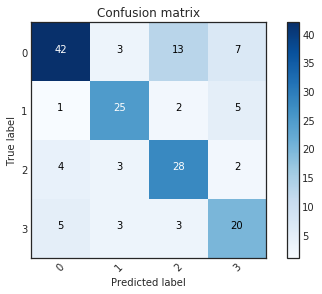

In [17]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(accuracy_score(preds, y))
print(classification_report(preds, y, target_names=data.classes))

0.6927710843373494
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        65
           1       0.74      0.76      0.75        33
           2       0.61      0.76      0.67        37
           3       0.59      0.65      0.62        31

   micro avg       0.69      0.69      0.69       166
   macro avg       0.68      0.70      0.69       166
weighted avg       0.71      0.69      0.69       166



In [ ]:
log_preds, y =  learn.TTA(is_test=True)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
print(preds)

In [19]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [20]:
embeddings = get_embeddings('7')

In [21]:
import pickle

# with open('datasets/HPA_challenge_2018/Hirano3D/tmp/Embeddings_Hirano3D_dn121_512_transferHPA_v4.pkl', 'wb') as handle:
#     pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('datasets/HPA_challenge_2018/Hirano3D/tmp/Embeddings_Hirano3D_dn121_512_transferHPA_v4.pkl', 'rb') as handle:
    embeddings_loaded = pickle.load(handle)
    
# embeddings = embeddings_loaded

In [22]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(664, 512)
(166, 512)
(60, 512)
(664,)
(166,)
(60,)


In [25]:
import umap

ModuleNotFoundError: No module named 'umap'

In [24]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

NameError: name 'umap' is not defined

In [ ]:
# data.test_ds.fnames

In [ ]:
y_test = np.zeros(60)
y_test[:30] = y_test[:30] +1 
y_test

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(4):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)

    axarr[0].set_xlim(-10,5)
    axarr[0].set_ylim(-5,8)
    
for i in [0,1]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-10,5)
    axarr[1].set_ylim(-5,8)


In [ ]:
def opt_th(preds, targs, start=0.2, end=0.6, step=0.05):
    ths = np.arange(start,end,step)
    res = [f1_macro(preds, targs, thresh=th, kind='macro') for th in ths]
    idx = np.argmax(res)
    return ths[idx], res

In [ ]:
# get train predictions

preds_trn, targs_trn =  learn.predict_with_targs('trn')

preds_trn_torch = torch.from_numpy(preds_trn)
targs_trn_torch = torch.from_numpy(targs_trn)

opt_th(preds_trn_torch, targs_trn_torch)

In [ ]:
print(preds_val_torch[0])
print(preds_trn_torch[0])

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)

In [ ]:
# get val predictions

preds_val, targs_val =  learn.predict_with_targs('val')

preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

In [ ]:
# get val predictions

preds_val, targs_val =  learn.TTA(n=8)
preds_val= np.mean(preds_val, axis=0)
preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

In [ ]:
# get val predictions

preds_val, targs_val =  learn.TTA(8)
preds_val= np.mean(preds_val, axis=0)
preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

In [ ]:
# get test predictions

preds_test, targs_test =  learn.predict_with_targs('test')

In [ ]:
targs_test[:50]

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
data.test_dl.sampler

In [ ]:
test_names = data.test_ds.fnames
test_names[:10]

In [ ]:
def create_submission(preds_file, output_name, th = 0.3, TTA=False):
    
    # creating submission file
    
    if TTA:
        preds = preds_file.mean(axis=0)
        print('TTA:',preds.shape)
    else: preds = preds_file
    
    clss = np.arange(0, len(data.classes)) # get class indeces
    res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > th)])) for p in preds]) # generating output

    # ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
    for i in range(res.shape[0]):
        if res[i] == '':
            res[i] = preds[i].argmax()

    # getting image Ids
    fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

    # creating submission file
    sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
    sub_df.to_csv(output_name, index_label='Id')

In [ ]:
submission_name = PATH + 'submissions/Res18_pre_0.42_t-03.csv'

create_submission(log_preds, submission_name, th=0.3, TTA=True)

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [ ]:
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 1000)
# score = 0.0
# test_threshold=0.5*np.ones(28)
# best_threshold=np.zeros(28)
# best_val = np.zeros(28)
# for i in range(28):
#     for threshold in thresholds:
#         test_threshold[i] = threshold
#         max_val = np.max(preds_y)
#         val_predict = (preds_y > test_threshold)
#         score = f1_score(valid_y > 0.5, val_predict, average='macro')
#         if score > best_val[i]:
#             best_threshold[i] = threshold
#             best_val[i] = score
#     print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
#     test_threshold[i] = best_threshold[i]
# print("Best threshold: ")
# print(best_threshold)
# print("Best f1:")
# print(best_val)